In [1]:
import pandas as pd
import geopandas as gpd
import shapely
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from geoalchemy2 import Geometry, WKTElement
import  sqlalchemy 
from scipy.optimize import lsq_linear
from shapely.geometry import MultiLineString

pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

pg = open('db_credentials.txt')
db = pg.read()
pg.close()
engine = sqlalchemy.create_engine(db)

LIST OF VALUES
VALUE 1
Roadway Type
DESCRIPTION Street
VALUE 2
DESCRIPTION Highway
VALUE 3
DESCRIPTION Bridge
VALUE 4
DESCRIPTION Tunnel
VALUE 5
DESCRIPTION Boardwalk
VALUE 6
DESCRIPTION Path/Trail
VALUE 7
DESCRIPTION Step Street
VALUE 8
DESCRIPTION Driveway
VALUE 9
DESCRIPTION Ramp
VALUE 10
DESCRIPTION Alley
VALUE 11
DESCRIPTION Unknown
VALUE 12
DESCRIPTION Non-Physical Street Segment
VALUE 13
DESCRIPTION U-Turn
VALUE 14
DESCRIPTION Ferry Route

VALUE 0
DESCRIPTION Street other than vehicle only street.
VALUE 1
DESCRIPTION Railroad
VALUE 2
DESCRIPTION Water Edge / Shoreline
VALUE 3
DESCRIPTION Census Block Boundary
VALUE 5
DESCRIPTION Paper Street: This is a legally mapped, but unbuilt street. Such streets are
common in areas of Staten Island anticipating development. May exist in all boroughs.
VALUE 6
DESCRIPTION Private Street: This is a physically existing street which is not owned by the
City and is not officially mapped. For example, streets in the Fort Totten and Breezy Point
sections of Queens.
VALUE 7
DESCRIPTION District Boundary: Physically non-existent boundary for a community district, a
police precinct, or a fire company.
VALUE 8
DESCRIPTION Physical Non-Street Boundary: Physically existing un-addressable boundary
(such as a rock wall cemetery edge).
VALUE 9
DESCRIPTION Paper Street and Census/District Boundary: A legally mapped, but unbuilt
street that also acts as a census block or district boundary.
VALUE A
DESCRIPTION Alley: a narrow street or passageway between and behind city buildings.
VALUE W
DESCRIPTION Path, Non-Vehicular, Addressable: This is a walking path that contains
addresses. For example, some boardwalks and some walking paths in housing projects.
VALUE C
DESCRIPTION CCO (Corporation Counsel Opinion). A CCO is an opinion by the City's Law
Department that a street area, not owned by the City, has been dedicated for public use,
consistent with the requirements of General City Law, Section 36(2). That allows the City to
use public funds for various improvements and services, including paving of the roadway
and installing sewers. The request usually relates to planned work by the City's Department
of Transportation, Department of Design and Construction, and Department of
Environmental Protection.
VALUE F
DESCRIPTION Ferry Route: A schematic representation of a ferry’s passage through a water
body. Please note that only selected ferry routes required for the bicycle routing within NYC
are included.

SEGTYPE
VALUE B
DESCRIPTION Both: Segment is both generic and roadbed; the center roadbed segment of a
divided roadway containing an odd number of roadbeds.
VALUE C
DESCRIPTION Connector: Segments used to connect adjacent roadbeds of a divided street.
Typically these exist to allow traffic flow from one roadbed to another.
VALUE E
DESCRIPTION Entrance/Exit Ramp: Connects a highway to a different street or highway.
VALUE F
DESCRIPTION Faux Segment: These are used when a street or ramp physically ends at a
roadbed, but connectivity needs to be maintained with the generic segment.
VALUE G
DESCRIPTION Generic Segment: An imaginary single line representation of a physically
divided street.
VALUE R
DESCRIPTION Roadbed Segment: Depicts physically separated carriageway segments of a
particular street.
VALUE T
DESCRIPTION Terminator: Used to model situations where a divided section of a street
terminates, but the street itself continues.
VALUE U
DESCRIPTION Undivided Street: All other LION segments that do not fall into any of the
above categories.
VALUE S
DESCRIPTION Suppressed: Undivided segment to be suppressed in a generic view of LION

In [2]:
# lion, segmenttyp != G, 
# rw_type != 6, empty, 7, 8, 12, 14, 11, 10

lion_clipped = gpd.read_postgis('SELECT * FROM lion_clipped', engine, geom_col='shape')
taxis_clipped = gpd.read_postgis('SELECT * FROM taxis_2015_clipped', engine, geom_col='pickup_point')
nodes_clipped = gpd.read_postgis('SELECT * FROM node_clipped', engine, geom_col='shape')

(array([9.4170e+03, 1.3022e+04, 6.8390e+03, 2.1740e+03, 9.7700e+02,
        5.6100e+02, 2.0000e+02, 8.5000e+01, 2.2000e+01, 7.0000e+00]),
 array([3.03393601e-01, 4.20336979e+01, 8.37640023e+01, 1.25494307e+02,
        1.67224611e+02, 2.08954915e+02, 2.50685220e+02, 2.92415524e+02,
        3.34145828e+02, 3.75876133e+02, 4.17606437e+02]),
 <a list of 10 Patch objects>)

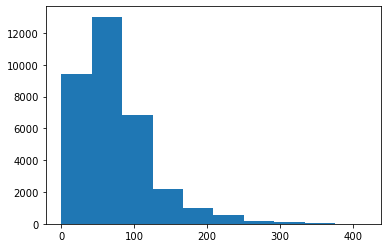

In [3]:
plt.hist(taxis_clipped['dist_to_nn_pickup'])

(array([9.3220e+03, 1.1744e+04, 6.8630e+03, 2.3540e+03, 1.6000e+03,
        8.7700e+02, 3.5700e+02, 1.4200e+02, 4.4000e+01, 1.0000e+00]),
 array([2.87260938e-01, 4.54553076e+01, 9.06233543e+01, 1.35791401e+02,
        1.80959448e+02, 2.26127494e+02, 2.71295541e+02, 3.16463588e+02,
        3.61631634e+02, 4.06799681e+02, 4.51967728e+02]),
 <a list of 10 Patch objects>)

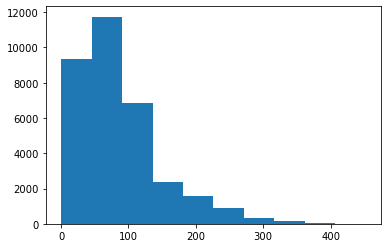

In [4]:
plt.hist(taxis_clipped['dist_to_nn_dropoff'])

In [5]:
taxis_clipped

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_point,dropoff_point,id,nn_pickup,nn_dropoff,dist_to_nn_pickup,dist_to_nn_dropoff
0,2,2015-05-03 02:11:01,2015-05-03 02:19:23,1,1.09,-74.004555,40.730824,1,N,-73.987587,40.725513,1,7.0,0.5,0.5,2.08,0.0,0.3,10.38,POINT (982987.639 205535.318),0101000020D70800006C50392755242E41C3C9524787DA...,123,20406,9051343,46.398214,30.561776
1,1,2015-05-02 23:39:58,2015-05-02 23:47:23,1,1.00,-73.994293,40.719948,1,N,-73.979874,40.713902,2,6.5,0.5,0.5,0.00,0.0,0.3,7.80,POINT (985831.909 201572.982),0101000020D70800008C3F74F80A352E41F079BDC55556...,141,9038437,16166,91.527631,35.667015
2,2,2015-05-16 15:24:56,2015-05-16 15:29:11,5,0.66,-73.999741,40.718128,1,N,-73.993050,40.725422,2,5.0,0.0,0.5,0.00,0.0,0.3,5.80,POINT (984321.907 200909.991),0101000020D7080000819A8EF180182E41D9748A187BD9...,232,20479,20694,72.186569,11.029840
3,2,2015-05-24 15:54:24,2015-05-24 15:59:29,2,0.85,-73.987892,40.719082,1,N,-73.988327,40.727791,1,5.5,0.0,0.5,0.00,0.0,0.3,6.30,POINT (987606.313 201257.675),0101000020D70800002E4062AFBA222E41A39E38CC74F4...,242,77966,20794,187.972200,88.945215
4,2,2015-05-01 03:37:28,2015-05-01 03:46:22,1,1.52,-73.997269,40.716648,1,N,-73.983772,40.731800,1,8.5,0.5,0.5,1.50,0.0,0.3,11.30,POINT (985007.154 200370.756),0101000020D7080000EB59D5FA962C2E41E8A678F41B22...,309,20566,9052815,88.171008,59.687397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33299,2,2015-05-24 18:45:17,2015-05-24 18:54:44,2,1.65,-73.980530,40.726044,1,N,-74.001404,40.731205,1,9.0,0.0,0.5,1.96,0.0,0.3,11.76,POINT (989646.608 203794.450),0101000020D7080000825EB0DD69062E41BE8FF328521B...,1099835,9052456,20421,14.662564,50.964185
33300,2,2015-05-24 18:45:20,2015-05-24 18:50:38,5,0.93,-73.988251,40.718376,1,N,-74.001755,40.719196,2,5.5,0.0,0.5,0.00,0.0,0.3,6.30,POINT (987506.949 201000.547),0101000020D708000096E33C28A7052E4193F02B249992...,1099849,78243,20369,31.417546,81.613409
33301,2,2015-05-12 17:04:25,2015-05-12 17:06:05,5,0.19,-73.983589,40.731792,1,N,-73.985992,40.732780,1,3.0,1.0,0.5,0.96,0.0,0.3,5.76,POINT (988798.238 205888.724),0101000020D7080000E6599F3DC8272E41C2BCEE8F442D...,1099908,9052815,20910,11.341019,299.601421
33302,1,2015-05-12 17:04:26,2015-05-12 17:10:07,1,1.00,-73.990135,40.732437,1,N,-73.998199,40.726166,1,6.0,1.0,0.5,1.55,0.0,0.3,9.35,POINT (986983.991 206123.331),0101000020D7080000EB16F01D5A0D2E41644000A2F2E1...,1099914,9052860,78598,9.608833,38.138816


In [6]:
lion_clipped['nodeidfrom'] = lion_clipped['nodeidfrom'].astype(int)
lion_clipped['nodeidto'] = lion_clipped['nodeidto'].astype(int)



# REVIST THIS: SHOULD DUPLICATES BE DROPPED?  LOOK AT SEGCOUNT IN MAP
# IF THERE ARE DUPLICATES, SELECT WHERE RW_IS NOT ZERO

#lion_filt = lion_clipped.drop_duplicates(subset=['nodeidfrom','nodeidto','nodelevelf','nodelevelt'], keep='first', inplace=False).reset_index()
#lion_filt['seg_id'] = np.arange(lion_filt.shape[0])
#lion_filt.set_index(['node_low','node_high'], inplace = True)

In [7]:
list(lion_clipped.columns)

['objectid',
 'street',
 'safstreetname',
 'featuretyp',
 'segmenttyp',
 'incexflag',
 'rb_layer',
 'nonped',
 'trafdir',
 'trafsrc',
 'specaddr',
 'facecode',
 'seqnum',
 'streetcode',
 'safstreetcode',
 'lgc1',
 'lgc2',
 'lgc3',
 'lgc4',
 'lgc5',
 'lgc6',
 'lgc7',
 'lgc8',
 'lgc9',
 'boe_lgc',
 'segmentid',
 'segcount',
 'locstatus',
 'lzip',
 'rzip',
 'lboro',
 'rboro',
 'l_cd',
 'r_cd',
 'latomicpolygon',
 'ratomicpolygon',
 'lct2010',
 'lct2010suf',
 'rct2010',
 'rct2010suf',
 'lcb2010',
 'lcb2010suf',
 'rcb2010',
 'rcb2010suf',
 'lct2000',
 'lct2000suf',
 'rct2000',
 'rct2000suf',
 'lcb2000',
 'lcb2000suf',
 'rcb2000',
 'rcb2000suf',
 'lct1990',
 'lct1990suf',
 'rct1990',
 'rct1990suf',
 'lassmdist',
 'lelectdist',
 'rassmdist',
 'relectdist',
 'splitelect',
 'lschldist',
 'rschldist',
 'splitschl',
 'lsubsect',
 'rsubsect',
 'sandistind',
 'mapfrom',
 'mapto',
 'borobndry',
 'mh_ri_flag',
 'xfrom',
 'yfrom',
 'xto',
 'yto',
 'arccenterx',
 'arccentery',
 'curveflag',
 'radius',


In [8]:
#lion_filt[lion_filt['rw_type'] == 6]
#list(lion_clipped.columns)
#n = (lion_filt['rw_type'] == 6).to_numpy()
#lion_filt.iloc[n]
#lion_clipped.dtypes #[lion_clipped['rw_type'] == 6]

lion_clipped['feature_filt'] = lion_clipped.apply(lambda x : (x['featuretyp'].strip() == '0') # street
                                            and ((x['rw_type'].strip() == '1') # street
                                                 or (x['rw_type'].strip() == '2') # highway
                                                 or (x['rw_type'].strip() == '3') # bridge
                                                 or (x['rw_type'].strip() == '4') # tunnel
                                                 or (x['rw_type'].strip() == '9')) # ramp
                                            and (x['segmenttyp'] != 'G') # generic
                                            and (x['segmenttyp'] != 'F') # faux
                                            and (x['trafdir'] != 'P') # pedestrian 
                                                  ,axis = 1) 

<ipython-input-9-0a273b673bc5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt.drop_duplicates(subset=['nodeidfrom','nodeidto','nodelevelf','nodelevelt'],


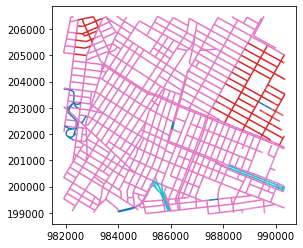

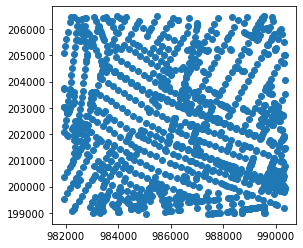

In [9]:
lion_filt = lion_clipped[lion_clipped['feature_filt']]
lion_filt.drop_duplicates(subset=['nodeidfrom','nodeidto','nodelevelf','nodelevelt'],
                          keep='first', inplace = True)
lion_filt.reset_index(inplace = True)
lion_filt.plot(column='posted_speed')
nodes_clipped.plot()

for each node, find all segments with the same nodeto
for each of those segments, find nodelevelt
if not all nodelevelt are equal, delete this node

find all segments with node from this node
get the node to of these segments
create edge with weight of seg_length of both roads

In [10]:
nodes_clipped

,objectid,nodeid,vintersect,shape
0,14418,15287,,POINT (981924.972 199538.066)
1,14492,15370,,POINT (983060.380 199008.077)
2,14493,15371,,POINT (982049.040 199743.784)
3,14494,15372,,POINT (982158.744 199928.072)
4,14495,15373,,POINT (982247.176 199061.850)
...,...,...,...,...
1571,131601,9052850,,POINT (983318.094 204202.795)
1572,131602,9052851,,POINT (983326.688 204233.600)
1573,131612,9052858,,POINT (986990.004 206109.986)
1574,131613,9052860,,POINT (986993.119 206126.333)


In [11]:
nodes_clipped['nodeid'] = nodes_clipped['nodeid'].astype(int)
#nodes_clipped.set_index('nodeid', inplace = True)
print(nodes_clipped['nodeid'].max())
node_new = nodes_clipped['nodeid'].max() + 1

9052914


In [12]:
lion_filt.index

RangeIndex(start=0, stop=1980, step=1)

In [13]:
lion_filt

,index,objectid,street,safstreetname,featuretyp,segmenttyp,incexflag,rb_layer,nonped,trafdir,trafsrc,specaddr,facecode,seqnum,streetcode,safstreetcode,lgc1,lgc2,lgc3,lgc4,lgc5,lgc6,lgc7,lgc8,lgc9,boe_lgc,segmentid,segcount,locstatus,lzip,rzip,lboro,rboro,l_cd,r_cd,latomicpolygon,ratomicpolygon,lct2010,lct2010suf,rct2010,rct2010suf,lcb2010,lcb2010suf,rcb2010,rcb2010suf,lct2000,lct2000suf,rct2000,rct2000suf,lcb2000,lcb2000suf,rcb2000,rcb2000suf,lct1990,lct1990suf,rct1990,rct1990suf,lassmdist,lelectdist,rassmdist,relectdist,splitelect,lschldist,rschldist,splitschl,lsubsect,rsubsect,sandistind,mapfrom,mapto,borobndry,mh_ri_flag,xfrom,yfrom,xto,yto,arccenterx,arccentery,curveflag,radius,nodeidfrom,nodeidto,nodelevelf,nodelevelt,conparity,twisted,rw_type,physicalid,genericid,nypdid,fdnyid,lblockfaceid,rblockfaceid,legacyid,status,streetwidth_min,streetwidth_max,streetwidth_irr,bikelane,bike_trafdir,active_flag,posted_speed,snow_priority,number_travel_lanes,number_park_lanes,number_total_lanes,carto_display_level,fcc,row_type,llo_hyphen,lhi_hyphen,rlo_hyphen,rhi_hyphen,fromleft,toleft,fromright,toright,join_id,shape_length,shape,feature_filt
0,0,87405,VARICK STREET,,0,U,,B,,A,DOT,,4535,00020,132685,,01,,,,,,,,,1,0031791,1,,10013,10013,1,1,101,101,309,310,33,,33,,3014,,3013,,33,,33,,3015,,3014,,33,,33,,66,012,66,009,,02,02,None,3B,3B,,12A,12A,,,982363,201511,982394,201751,0,0,,0,20200,20202,M,M,,,1,732.0,610.0,,,1222601429,1222604095,0031791,2,58.0,58.0,,2,TF,None,25,C,3,2,5,None,,,15,23,12,24,15,23,12,24,1453501000000,242.417003,"MULTILINESTRING ((982362.711 201510.952, 98239...",True
1,1,87406,HOLLAND TUNNEL EXIT,,0,E,,B,V,W,DCP,,2824,07150,197450,,01,,,,,,,,,1,0103460,1,,10013,10013,1,1,101,101,328,326,33,,33,,3007,,3005,,33,,33,,3007,,3007,,33,,33,,66,012,66,012,,02,02,None,3B,3B,,12A,12A,,,982035,201963,982079,201911,982179,202040,R,163,20218,20198,M,M,,,9,569.0,455.0,,,1222606233,1222606821,0103460,2,28.0,38.0,,,,None,,V,3,,3,None,,,None,None,None,None,0,0,0,0,1282401000000,68.522405,"MULTILINESTRING ((982034.953 201963.185, 98204...",True
2,2,87409,HUDSON STREET,,0,U,,B,,W,DCP,,2860,00320,123190,,01,,,,,,,,,1,0031886,1,,10013,10013,1,1,102,102,122,226,37,,37,,1015,,3007,,53,,51,,1008,,2004,,53,,51,,66,068,66,068,,02,02,None,1B,1B,,12A,12A,,,982152,203692,982155,203720,0,0,,0,20252,20253,M,M,,,1,610.0,494.0,,,1222603848,1222603732,0031886,2,50.0,50.0,,2,FT,None,25,C,2,2,4,None,,,None,None,None,None,0,0,0,0,1286001000000,28.102279,"MULTILINESTRING ((982151.632 203691.948, 98215...",True
3,3,87410,CHURCH STREET,,0,U,,B,,W,DOT,,0920,01110,115350,,01,,,,,,,,,1,0023396,1,,10013,10007,1,1,101,101,201,111,33,,33,,2011,,1009,,33,,33,,2011,,1010,,33,,33,,66,105,66,007,,02,02,None,3A,3A,,12B,12A,,,982159,199928,982283,200134,0,0,,0,15372,20186,M,M,,,1,151.0,135.0,,,0212261957,0212261092,0023396,2,60.0,62.0,,2,FT,None,25,C,3,2,5,None,,,174,192,175,193,174,192,175,193,1092001000000,240.328304,"MULTILINESTRING ((982158.744 199928.072, 98228...",True
4,4,87411,HUDSON STREET,,0,U,,B,,W,DOT,,2860,00340,123190,,01,,,,,,,,,1,0031890,1,,10013,10013,1,1,102,102,105,214,37,,37,,1012,,3002,,53,,51,,1002,,2002,,53,,51,,66,068,66,068,,02,02,None,1B,1B,,12A,12A,,,982190,203997,982221,204262,0,0,,0,20254,20268,M,M,,,1,612.0,496.0,,,1222604300,1222601433,0031890,2,50.0,50.0,,2,FT,None,25,C,2,2,4,None,,,323,339,324,344,323,339,324,344,1286001000000,267.010275,"MULTILINESTRING ((982189.647 203996.931, 98222...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,2792,113726,4 AVENUE,,0,U,,B,,W,DOT,,2525,02050,110350,,01

In [14]:
#from shapely.geometry import LineString
#line = LineString([(0, 0), (1, 1)])

#nodes_clipped['to_filt'] = True
#lion_filt['to_filt'] = True

#lion_filt.drop(columns='shape_wkt', inplace = True)
#idx = lion_filt.index[-1]

lion_index = lion_filt.index

for i in nodes_clipped.index:
    cur_id = nodes_clipped.loc[i,'nodeid']
    #segs_to_idx = lion_filt.index[lion_filt['nodeidto'] == cur_id]
    segs_to = lion_filt.loc[lion_filt['nodeidto'] == cur_id,:]
    levels = segs_to['nodelevelt'].unique()
    if len(levels) > 1:
        #segs_from_idx = lion_filt.index[lion_filt['nodeidfrom'] == 93485]#nodes_clipped.loc[i,'nodeid']]
        #segs_from = lion_filt.loc[segs_from_idx]
        #new_nodes = []
        print(levels)
        for l in levels:
            #np.where(df1['stream'] == 2, 10,20)
            #print(lion_filt[(lion_filt['nodeidto'] == cur_id)  & (lion_filt['nodelevelt'] == b)])
            locs_to = (lion_filt['nodeidto'] == cur_id) & (lion_filt['nodelevelt'] == l)
            lion_filt.loc[locs_to, 'nodeidto'] = node_new
            #print(lion_filt.loc[locs_to,'nodeidto'])
            
            locs_from = (lion_filt['nodeidfrom'] == cur_id) & (lion_filt['nodelevelf'] == l)
            lion_filt.loc[locs_from, 'nodeidfrom'] = node_new
            #print(lion_filt.loc[locs_from, 'nodeidfrom'])
            
            node_new = node_new + 1
        #break
            
#             lion_filt['nodeidto'] = np.where((lion_filt['nodeidto'] == nodes_clipped.loc[i,'nodeid']) 
#                                              & (lion_filt['nodelevelt'] == b),
#                                              node_new, lion_filt['nodeidto'])
#             lion_filt['nodeidfrom'] = np.where((lion_filt['nodeidfrom'] == nodes_clipped.loc[i,'nodeid']) 
#                                                & (lion_filt['nodelevelf'] == b),
#                                              node_new, lion_filt['nodeidfrom'])
            #new_nodes.append([new_node,b])
            
#         print(levels)
#         print(new_nodes)
#         break
#     #for j,row in nodes_to.iterrows():
#     #print(segs_to)
#     nu = segs_to['nodelevelt'].nunique()
#     # get list of node level to for segs_to
#     # create list of new node_ids for given node level
#     # assign new node ids
#     # get list of node level from node
#     # assign same node ids
#     if nu > 1:
#         print(nu)
#         nodes_clipped.loc[i,'to_filt'] = True
#         segs_from_idx = lion_filt.index[lion_filt['nodeidfrom'] == nodes_clipped.loc[i,'nodeid']]
#         segs_from = lion_filt.loc[segs_from_idx]
#         segs_join = segs_to.merge(segs_from, left_on = ['nodeidto','nodelevelt'],
#                                     right_on = ['nodeidfrom','nodelevelf'], how = 'inner')
#         for j,row in segs_join.iterrows():
#             node_from_new = row['nodeidfrom_x']
#             point_from_new = nodes_clipped[nodes_clipped['nodeid'] == node_from_new]['shape']
#             node_to_new = row['nodeidto_y']
#             point_to_new = nodes_clipped[nodes_clipped['nodeid'] == node_to_new]['shape']
#             new_shape = MultiLineString([LineString([point_from_new.values[0], point_to_new.values[0]])])
#             #print(new_shape)
#             lion_filt.at[idx] = pd.Series({'nodeidfrom' : row['nodeidfrom_x'],
#                              'nodeidto' : row['nodeidto_y'],
#                              'shape_length' : row['shape_length_y'] + row['shape_length_y'],
#                              'shape' : new_shape, 'to_filt' : True})
#             idx = idx + 1
#             #print(new_shape)
        
#         #lion_filt.loc[segs_from_idx, 'nodeidto'] = -1
#         #lion_filt.loc[segs_from_idx, 'nodeidfrom'] = -1
#         lion_filt.loc[segs_to_idx, 'nodeidto'] = -1
#         lion_filt.loc[segs_from_idx, 'nodeidfrom'] = -1  
#         lion_filt.loc[segs_from_idx, 'nodeidto'] = -1
#         lion_filt.loc[segs_to_idx, 'nodeidfrom'] = -1
    #break
#nodes_to
#nodes_from
#print(nu)
#nodes_join

['Q' 'M']
['M' 'Q']
['M' 'Q']
['M' 'I']
['I' 'M']


C:\Users\comp\anaconda3\envs\geopandas_env\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['M' 'Q']
['M' 'Q']
['Q' 'M']
['Q' 'M']
['Q' 'M']
['Q' 'M']
['Q' 'M']
['Q' 'M']
['Q' 'M']
['M' 'Q']
['Q' 'M']
['Q' 'M']
['Q' 'M']
['Q' 'M']
['Q' 'M']
['M' 'Q']
['Q' 'M']
['Q' 'M']
['Q' 'M']
['Q' 'M']
['Q' 'M']
['Q' 'M']
['I' 'M']


In [15]:
lion_filt['node_low'] = lion_filt.apply(lambda x : min(x['nodeidto'], x['nodeidfrom']), axis = 1)
lion_filt['node_high'] = lion_filt.apply(lambda x : max(x['nodeidto'], x['nodeidfrom']), axis = 1)

<ipython-input-15-3ffca3cc4ae3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['node_low'] = lion_filt.apply(lambda x : min(x['nodeidto'], x['nodeidfrom']), axis = 1)
<ipython-input-15-3ffca3cc4ae3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['node_high'] = lion_filt.apply(lambda x : max(x['nodeidto'], x['nodeidfrom']), axis = 1)


In [16]:
# lion_filt = lion_filt[(lion_filt['nodeidto'] != -1) & (lion_filt['nodeidfrom'] != -1)]
# lion_filt.plot()

In [17]:
# lion_filt['velocity'] = 0
# lion_filt['seg_id'] = np.arange(lion_filt.shape[0])
# lion_filt['shape_wkt'] = lion_filt['shape'].apply(lambda x : WKTElement(x,srid=2263))
# lion_filt[['seg_id','shape_wkt','velocity','nodeidto','nodeidfrom']].to_sql('lion_velocity', engine, if_exists='replace', index=False,
#                                        dtype={'shape_wkt': Geometry('MULTILINESTRING', srid= 2263)})

In [18]:
def getDGedges(row):
    if row['trafdir'] == 'T':
        return [(row['nodeidfrom'],row['nodeidto'], {'weight' : row['shape_length']}), (row['nodeidto'],row['nodeidfrom'], {'weight' : row['shape_length']})]
    elif row['trafdir'] == 'W':
        return [(row['nodeidfrom'],row['nodeidto'], {'weight' : row['shape_length']})]
    elif row['trafdir'] == 'A':
        return [(row['nodeidto'],row['nodeidfrom'], {'weight' : row['shape_length']})]
    else:
        print(row['trafdir'])
        raise Exception('TRAFDIR DID NOT PROCESS')

lion_filt['DG_node'] = lion_filt.apply(lambda x : getDGedges(x), axis = 1)
lion_filt.set_index(['node_low','node_high'], inplace = True)
lion_filt['seg_id'] = np.arange(lion_filt.shape[0])

<ipython-input-18-be0b62834e0f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['DG_node'] = lion_filt.apply(lambda x : getDGedges(x), axis = 1)
<ipython-input-18-be0b62834e0f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['seg_id'] = np.arange(lion_filt.shape[0])


In [19]:
#lion_filt.loc[(20868,9052926),:]

In [20]:
to_unique = lion_filt['nodeidto'].unique()
from_unique = lion_filt['nodeidto'].unique()
all_unique = np.concatenate((to_unique, from_unique))
unique_only = np.unique(all_unique)

In [21]:
print(len(to_unique))
print(len(from_unique))
print(len(all_unique))
print(len(unique_only))
print(unique_only.max())

1425
1425
2850
1425
9052970


In [22]:
# NOTE: some nodes will become disconnected when filtering the lion dataset.

G = nx.DiGraph()
G.add_nodes_from(all_unique)
#edges = list(lion_filt[['nodeidfrom','nodeidto','weight']].to_records(index=False))
for i,row in lion_filt.iterrows():
    G.add_edges_from(row['DG_node'])
#G.add_edges_from(edges)

In [23]:
paths_all = dict(nx.all_pairs_dijkstra_path(G,weight = 'weight'))

In [24]:
taxis_clipped = taxis_clipped[taxis_clipped['nn_pickup'] != taxis_clipped['nn_dropoff']]
taxis_clipped['datetime_pickup'] = pd.to_datetime(taxis_clipped['tpep_pickup_datetime'])
taxis_clipped['datetime_dropoff'] = pd.to_datetime(taxis_clipped['tpep_dropoff_datetime'])
taxis_clipped['trip_time'] = taxis_clipped.apply(lambda x: (x['datetime_dropoff']-x['datetime_pickup']).seconds, axis = 1)

<ipython-input-24-31807cac3a99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxis_clipped['datetime_pickup'] = pd.to_datetime(taxis_clipped['tpep_pickup_datetime'])
<ipython-input-24-31807cac3a99>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxis_clipped['datetime_dropoff'] = pd.to_datetime(taxis_clipped['tpep_dropoff_datetime'])
<ipython-input-24-31807cac3a99>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [25]:
# ADD FIRST SEGMENT TYPE AND LAST SEGMENT TYPE TO THIS
# NO PICKUPS/DROPOFFS ON TUNNELS, BRIDGES, OR HIGHWAYS
lion_filt.loc[:,'path_count'] = 0

def getPathData(p):
    p_seg_ids = []
    p_seg_lengths = []
    p_seg_shapes = []
    p_rw_types = []
    for i in np.arange(1,len(p)):
        nodes_temp = [p[i], p[i-1]]
        node_min = min(nodes_temp)
        node_max = max(nodes_temp)
        row = lion_filt.loc[(node_min,node_max)]
        lion_filt.loc[(node_min,node_max),'path_count'] = lion_filt.loc[(node_min,node_max),'path_count'] + 1
        p_seg_ids.append(int(row['seg_id']))
        p_seg_lengths.append(float(row['shape_length']))
        p_rw_types.append(row['rw_type'])
        for shape in row['shape']:
            p_seg_shapes.append(shape)
    return p_seg_ids, p_seg_lengths, MultiLineString(p_seg_shapes), p_rw_types

C:\Users\comp\anaconda3\envs\geopandas_env\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [26]:
taxis_clipped.loc[:,'path'] = '' 
taxis_clipped.loc[:,'path_distance_mi'] = 0
taxis_clipped.loc[:,'seg_ids'] = ''
taxis_clipped.loc[:,'seg_lengths'] = ''
taxis_clipped.loc[:,'path_shape'] = ''
taxis_clipped.loc[:,'rw_types'] = ''

trip_idx = taxis_clipped.index

for i in trip_idx:
    start_node = taxis_clipped.loc[i,'nn_pickup']
    end_node = taxis_clipped.loc[i,'nn_dropoff']
    try:
        path = paths_all[start_node][end_node]
        taxis_clipped.at[i, 'path'] = path
        seg_ids, seg_lengths, path_shape, rw_types = getPathData(path)
        taxis_clipped.loc[i, 'path_distance_mi'] = np.array(seg_lengths).sum()/5280
        taxis_clipped.at[i,'seg_lengths'] = seg_lengths
        taxis_clipped.at[i, 'seg_ids'] = seg_ids
        taxis_clipped.at[i, 'path_shape'] = path_shape
        taxis_clipped.at[i, 'rw_types'] = rw_types
    except:
        # no possible path
        taxis_clipped.loc[i, 'path_distance_mi'] = -1

    
taxis_clipped['dist_error'] = (taxis_clipped['trip_distance'] - taxis_clipped['path_distance_mi']).abs()

<ipython-input-26-d19f34ba8a14>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxis_clipped['dist_error'] = (taxis_clipped['trip_distance'] - taxis_clipped['path_distance_mi']).abs()


In [27]:
bins = np.arange(0,3.4,0.2)
labels = bins[0:-1] + 0.1

taxis_clipped['dbin'] = pd.cut(taxis_clipped['trip_distance'], bins=bins, labels = labels)
lower = taxis_clipped.groupby('dbin')['trip_time'].quantile(0.05)
upper = taxis_clipped.groupby('dbin')['trip_time'].quantile(0.95)
lower_arr = pd.DataFrame(lower).reset_index().to_numpy()
upper_arr = pd.DataFrame(upper).reset_index().to_numpy()


from scipy.interpolate import UnivariateSpline
spl_lower = UnivariateSpline(lower_arr[:,0],lower_arr[:,1])
spl_upper = UnivariateSpline(upper_arr[:,0],upper_arr[:,1])

taxis_clipped['trip_time_p5'] = taxis_clipped['trip_distance'].apply(lambda x : float(spl_lower(x)))
taxis_clipped['trip_time_p95'] = taxis_clipped['trip_distance'].apply(lambda x : float(spl_upper(x)))

<ipython-input-27-2ae523d8a3b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxis_clipped['dbin'] = pd.cut(taxis_clipped['trip_distance'], bins=bins, labels = labels)
<ipython-input-27-2ae523d8a3b9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxis_clipped['trip_time_p5'] = taxis_clipped['trip_distance'].apply(lambda x : float(spl_lower(x)))
<ipython-input-27-2ae523d8a3b9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [28]:
taxis_clipped['filt'] = taxis_clipped.apply(lambda x : 
                                            (x['trip_distance'] >= 0.5) 
                                            and (x['trip_distance'] <= 2) 
                                            and (x['trip_time'] >= x['trip_time_p5']) 
                                            and (x['trip_time'] <= x['trip_time_p95']) 
                                            and (x['dist_error'] < 0.2)
                                            and (x['path_distance_mi'] != -1)
                                            and (x['dist_to_nn_dropoff'] < 400)
                                            and (x['dist_to_nn_pickup'] < 400)
                                            and (x['rw_types'][0].strip() == '1')
                                            and (x['rw_types'][-1].strip() == '1'), axis = 1)

taxis_filt = taxis_clipped[taxis_clipped['filt']].reset_index()

<ipython-input-28-d2c68c17a214>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxis_clipped['filt'] = taxis_clipped.apply(lambda x :


In [29]:
taxis_filt['path_shape_wkt'] = taxis_filt['path_shape'].apply(lambda x : WKTElement(x,srid=2263))
taxis_filt[['index','id','nn_pickup',
            'nn_dropoff','path_shape_wkt',
           'pickup_longitude','pickup_latitude',
           'dropoff_longitude','dropoff_latitude']].to_sql('taxi_paths', engine, if_exists='replace', index=False,
                                       dtype={'path_shape_wkt': Geometry('MULTILINESTRING', srid= 2263)})

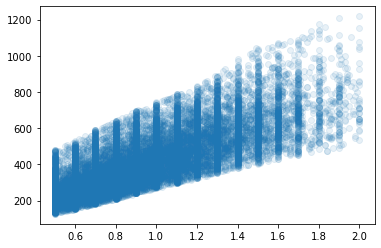

In [30]:
plt.scatter(taxis_filt['trip_distance'],taxis_filt['trip_time'], alpha = 0.1)

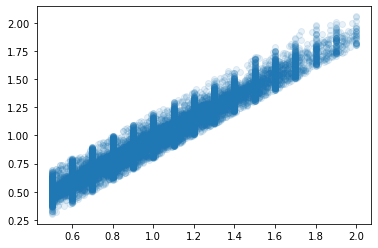

In [31]:
plt.scatter(taxis_filt['trip_distance'],taxis_filt['path_distance_mi'], alpha = 0.1)

In [32]:
#lion_filt['posted_speed'].astype(int)#pow(-1)
#pd.to_numeric(lion_filt['posted_speed'])
#lion_filt.drop(columns = ['shape_wkt'], inplace = True)

lion_filt.replace(to_replace = '  ', value = {'posted_speed' : '50'}, inplace = True)
lion_filt['vel_ub'] = lion_filt['posted_speed'].astype(float).pow(-1).multiply(3600/5280).multiply(1.2)

C:\Users\comp\anaconda3\envs\geopandas_env\lib\site-packages\pandas\core\frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-32-f16cb63c163b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['vel_ub'] = lion_filt['posted_speed'].astype(float).pow(-1).multiply(3600/5280).multiply(1.2)


In [33]:
trip_filt_idx = taxis_filt.index
num_segments = lion_filt.shape[0]
A = np.zeros([len(trip_filt_idx), num_segments])

for i in trip_filt_idx:
    seg_coefs = np.zeros(num_segments)
    seg_coefs[taxis_filt.loc[i,'seg_ids']] = taxis_filt.loc[i,'seg_lengths']
    A[i] = seg_coefs

In [34]:
b = taxis_filt['trip_time'] 
lb = lion_filt['vel_ub'] # 85 mph
ub = np.ones(num_segments)*0.7 # 1 mph

x = lsq_linear(A, b, bounds = (lb, ub), verbose = 2, max_iter = 100)

   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         2.6498e+09                                    7.89e+07    
       1         5.2025e+08      2.13e+09       4.93e+00       1.89e+07    
       2         1.5146e+08      3.69e+08       2.39e+00       4.05e+06    
       3         1.2392e+08      2.75e+07       2.06e-01       7.22e+06    
       4         1.1561e+08      8.31e+06       8.24e-01       4.98e+06    
       5         1.1460e+08      1.01e+06       1.16e-01       4.71e+06    
       6         1.1410e+08      4.96e+05       3.05e-02       8.83e+05    
       7         1.0666e+08      7.44e+06       1.13e+00       4.40e+05    
       8         1.0468e+08      1.99e+06       6.35e-01       3.09e+05    
       9         1.0394e+08      7.37e+05       6.60e-02       6.41e+06    
      10         1.0374e+08      2.02e+05       1.13e-01       6.04e+06    
      11         1.0357e+08      1.66e+05       1.50e-02       5.57e+05    
      12    

In [40]:
x

 active_mask: array([0, 0, 0, ..., 0, 0, 0])
        cost: 99484342.91569209
         fun: array([ 22.68417253, -24.79711406,  73.26808243, ...,  51.41882788,
       108.85508824,  55.36555744])
     message: 'The maximum number of iterations is exceeded.'
         nit: 100
  optimality: 58728.41996927385
      status: 0
     success: False
           x: array([0.03424698, 0.11636364, 0.08469496, ..., 0.04572889, 0.03279213,
       0.03282523])

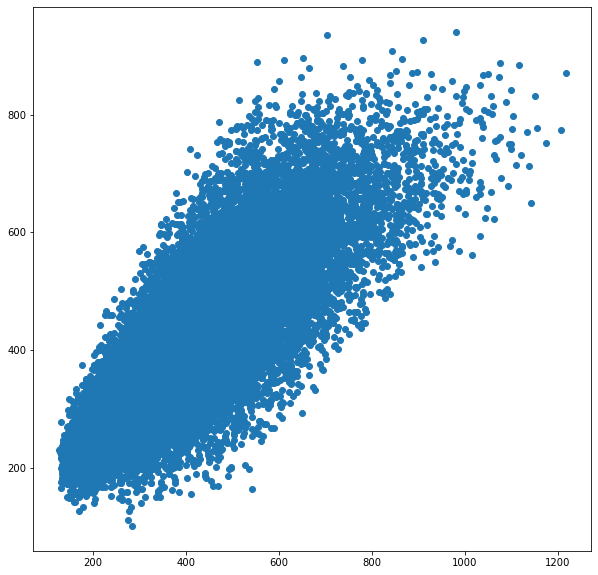

In [41]:
pred = np.matmul(A, x['x'])

plt.figure(figsize=(10,10))
plt.scatter(b, pred)

(array([142.,  64.,  42.,  37.,  50.,  35.,  44.,  45.,  51.,  33.,  62.,
         60.,  44.,  28.,  37.,  35.,  26.,  33.,  25.,  24.,  26.,  19.,
         16.,  22.,  14.,  13.,  13.,  15.,  14.,   5.,  15.,  12.,   9.,
         20.,  19.,  11.,  32.,  25.,  51.,  11.,  16.,  14.,  14.,  29.,
         30.,  45.,  83., 138., 289.,  27.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   3.,   1.,   0.,   0.,   2.,   1.,   4.,
          1.]),
 array([ 0.97402597,  1.37888586,  1.78374575,  2.18860563,  2.59346552,
         2.9983254 ,  3.40318529,  3.80804518,  4.21290506,  4.61776495,
         5.02262484,  5.42748472,  5.83234461,  6.23720449,  6.64206438,
         7.04692427,  7.45178415,  7.85664404,  8.26150392,  8.66636381,
         9.0712237 ,  9.47

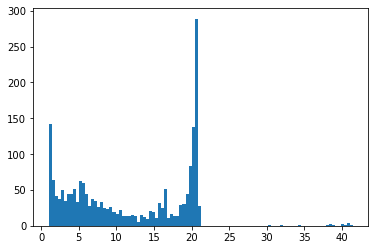

In [42]:
plt.hist((1/x['x'])*(1/5280)*3600, bins = 100)

In [43]:
lion_filt['velocity'] = (1/x['x'])*(1/5280)*3600
lion_filt['shape_wkt'] = lion_filt['shape'].apply(lambda x : WKTElement(x,srid=2263))

<ipython-input-43-5796603dc0a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['velocity'] = (1/x['x'])*(1/5280)*3600
<ipython-input-43-5796603dc0a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['shape_wkt'] = lion_filt['shape'].apply(lambda x : WKTElement(x,srid=2263))


In [44]:
lion_filt[['seg_id','shape_wkt','velocity','path_count','nodeidfrom','nodeidto']].to_sql('lion_velocity', engine, if_exists='replace', index=False,
                                       dtype={'shape_wkt': Geometry('MULTILINESTRING', srid= 2263)})